# Гипотезы (задачи)
1. <b>Отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение.</b> Насколько обучение сокращает время прохождения этапов?
<br>✔ По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?


2. <b>Cуществует ли зависимость между вероятностью оплаты и количеством обучений, которые начинал или завершал пользователь.</b> Нужно доказать, что успешное обучение само по себе влияет на оплату, и без разницы, каким этапом оно шло.
<br>✔ Кажется, повторное прохождение обучения положительно влияет на оплату, верно?


3. <b>Как часто пользователи начинают обучение после того, как они выбрали уровень сложности.</b> Это позволит нам понять, насколько прозрачен процесс взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.
<br>✔Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

In [47]:
import pandas as pd

# Сбор и обработка данных

In [48]:
# Отберем события, которые были произведены пользователями, зарегистрированными в 2018 году
events_df = pd.read_csv('7_4_Events.csv')
registrations_df_2018 = events_df[(events_df.event_type == 'registration')&(events_df.start_time >= '2018-01-01')&(events_df.start_time < '2019-01-01')]
registrations_df_2018 = registrations_df_2018.copy() 
registrated_users_2018 = registrations_df_2018['user_id']
events_df_2018 = events_df[events_df['user_id'].isin(registrated_users_2018)]
events_df_2018 = events_df_2018.copy()

# Отберем оплаты, которые были произведены пользователями, зарегистрированными в 2018 году
purchase_df = pd.read_csv('7_4_Purchase.csv')
purchase_df_2018 = purchase_df[purchase_df['user_id'].isin(registrated_users_2018)]
purchase_df_2018 = purchase_df_2018.copy()

In [49]:
# Посмотрим шапку в ДФ по событиям
events_df_2018.head(1)

,id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01T03:48:40,NaN,27832


In [50]:
# Проверим, какие события есть (все соответствуют flow)
events_df_2018['event_type'].unique()

array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice'], dtype=object)

In [51]:
# Посмотрим шапку в ДФ по оплатам
purchase_df_2018.head(1)

,id,user_id,event_datetime,amount
1171,16845,27845,2018-01-03T18:53:43,100


#### Проверка на пропущенные значения, дубли и типы данных:

In [52]:
events_df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              66959 non-null  int64  
 1   event_type      66959 non-null  object 
 2   selected_level  8342 non-null   object 
 3   start_time      66959 non-null  object 
 4   tutorial_id     32954 non-null  float64
 5   user_id         66959 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.6+ MB


In [53]:
# Дубли
events_df_2018['id'].value_counts().mean()

1.0

In [54]:
# Пропуски в selected_level
research_selected_level = events_df_2018.dropna(subset=['selected_level'])
research_selected_level['event_type'].unique()

array(['level_choice'], dtype=object)

In [55]:
# значения selected_level без пропусков
research_selected_level['selected_level'].unique()

array(['medium', 'hard', 'easy'], dtype=object)

In [56]:
# Пропуски в tutorial_id
research_tutorial_id = events_df_2018[events_df_2018['tutorial_id'] > 0 ]
research_tutorial_id['event_type'].unique()

array(['tutorial_start', 'tutorial_finish'], dtype=object)

In [57]:
purchase_df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1600 non-null   int64 
 1   user_id         1600 non-null   int64 
 2   event_datetime  1600 non-null   object
 3   amount          1600 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 62.5+ KB


In [58]:
# Дубли
purchase_df_2018['id'].value_counts().mean()

1.0

## Выводы после сбора данных
<b><u>По ДФ событий</u></b>:

✔Всего строк 66959. Дублей строк по id нет.
<br>✔<b>selected_level и tutorial_id не всегда имеют значения, но это объясняется особенностями ДФ:</b>
<br> - столбец selected_level не заполнен для всех событий кроме level_choice, что логично, поскольку уровень сложности (medium', 'hard', 'easy') выбирается только на событии выбора уровня сложности (level_choice)
<br> - tutorial_id заполнен только для событий обучения (tutorial_start', 'tutorial_finish)
<br>✔Также поле start_time имеет тип object, поэтому его нужно привести к типу datetime


<b><u>По ДФ покупок</u></b>:

✔Всего строк 1600. Дублей строк по id нет. Все строки не пустые.
<br>✔Поле event_datetime имеет тип object, поэтому его нужно привести к типу datetime

#### Преобразование типов

In [59]:
events_df_2018['start_time'] = pd.to_datetime(events_df_2018['start_time'], format='%Y-%m-%dT%H:%M:%S')
purchase_df_2018['event_datetime'] = pd.to_datetime(purchase_df_2018['event_datetime'], format='%Y-%m-%dT%H:%M:%S')
registrations_df_2018['start_time'] = pd.to_datetime(registrations_df_2018['start_time'], format='%Y-%m-%dT%H:%M:%S')

In [60]:
events_df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              66959 non-null  int64         
 1   event_type      66959 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      66959 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         66959 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.6+ MB


In [61]:
purchase_df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              1600 non-null   int64         
 1   user_id         1600 non-null   int64         
 2   event_datetime  1600 non-null   datetime64[ns]
 3   amount          1600 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 62.5 KB


Типы преобразованы

# Объединим датафреймы
Для поиска ответа по гипотезам, необходимо, чтобы все события и оплаты были в одном ДФ

In [62]:
purchase_df_2018['event_type'] = 'purchase' #добавяем столбец
# именяем названия столбцов
events_df_2018 = events_df_2018.rename(columns={'id':'event_id'}) 
purchase_df = purchase_df.rename(columns={'id':'purchase_id'})
total_events_df_2018 = pd.concat([events_df_2018,purchase_df_2018],sort=False) # объединяем
total_events_df_2018 = total_events_df_2018.reset_index(drop=True) # сбрасываем индекс

# Проверка гипотезы 1: Отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение.
✔</b> Насколько обучение сокращает время прохождения этапов?
<br>✔</b> По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

### Для начала нужно выделить датафреймы с 2 группами пользователей:
<b>1 - Пользователи, которые начали и закончили обучение.</b> Т.к. закончить обучение могут только начавшие обучение пользователи, то в данную группу будут входить пользователи, имеющие событие tutorial_finish
<br><b>2 - пользователи, которые не начинали обучение</b> Нужно вычислить пользователей, которые начали обучение и исключить их - это и будет группа пользователей, не начинавших обучение

** Фактически, могут быть еще группы пользователей, которые начали обучение, но не закончили, но данную группу в рамках первой гипотезы я рассматривать не буду, т.к. она не подходит под условие гипотезы.


In [63]:
 # 1 - пользователи, закончившие обучение
tutorial_finish_users = total_events_df_2018[total_events_df_2018['event_type'] == 'tutorial_finish']['user_id']
df_with_tutorial_finish_users = total_events_df_2018[total_events_df_2018['user_id'].isin(tutorial_finish_users)]
df_with_tutorial_finish_users = df_with_tutorial_finish_users.reset_index(drop=True)
 # 2 - пользователи, не начинавшие обучение
tutorial_start_users = total_events_df_2018[total_events_df_2018['event_type'] == 'tutorial_start']['user_id']
df_wo_tutorial_start_users = total_events_df_2018.drop(total_events_df_2018[total_events_df_2018['user_id'].isin(tutorial_start_users)].index)
df_wo_tutorial_start_users = df_wo_tutorial_start_users.reset_index(drop=True)
wo_tutorial_start_users = df_wo_tutorial_start_users['user_id']

In [64]:
df_with_tutorial_finish_users['event_type'].unique()

array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice', 'purchase'], dtype=object)

In [65]:
df_wo_tutorial_start_users['event_type'].unique()

array(['registration', 'level_choice', 'pack_choice', 'purchase'],
      dtype=object)

### Анализ временных промежутков между событиями
Как видно по предыдущим 2 строкам, после регистрации общее у обоих групп событие - это level_choice,а далее у двух групп события идут в том же порядке. Поэтому можно проанализировать разницу во времени между следующими событиями:
<br>✔ level_choice и registration
<br>✔ pack_choice и level_choice
<br>✔ purchase и pack_choice
<br>✔ purchase и registration

Для этого в каждом ДФ нужно выделить все эти события

#### Группа 1: level_choice и registration

In [66]:
registration_df_gr1 = df_with_tutorial_finish_users[df_with_tutorial_finish_users['event_type'] == 'registration']
registration_df_gr1 = registration_df_gr1[['user_id','start_time']].rename(columns={'start_time':'registration_time'})
registration_df_gr1['user_id'].value_counts().mean()

1.0

In [67]:
level_choice_df_gr1 = df_with_tutorial_finish_users[df_with_tutorial_finish_users['event_type'] == 'level_choice']
level_choice_df_gr1 = level_choice_df_gr1[['user_id','start_time']].rename(columns={'start_time':'level_choice_time'})
level_choice_df_gr1['user_id'].value_counts().mean()

1.0

In [68]:
merged_registration_level_choice_df_gr1 = registration_df_gr1.merge(level_choice_df_gr1,on='user_id',how='inner')
merged_registration_level_choice_df_gr1['timedelta'] = merged_registration_level_choice_df_gr1['level_choice_time'] - merged_registration_level_choice_df_gr1['registration_time']
merged_registration_level_choice_df_gr1['timedelta'].mean()
print ('Среднее время между level_choice и registration для группы 1: {}'.format(merged_registration_level_choice_df_gr1['timedelta'].mean()))

Среднее время между level_choice и registration для группы 1: 0 days 07:05:36.854819357


Чтобы оптимизировать процесс подсчета временных промежутков, посчитаем их в цикле с условием:

In [69]:
user_groups = [
    {'gr_1': tutorial_finish_users},
    {'gr_2': wo_tutorial_start_users}
]

for group in user_groups:
    user_group = list(group.keys())[0] # gr_1 и gr_2
    users_in_group = group[user_group] # tutorial_finish_users и wo_tutorial_start_users
    registration_df = total_events_df_2018[(total_events_df_2018['event_type'] == 'registration') & (total_events_df_2018['user_id'].isin(users_in_group))]                      
    level_choice_df = total_events_df_2018[(total_events_df_2018['event_type'] == 'level_choice') & (total_events_df_2018['user_id'].isin(users_in_group))]
    pack_choice_df = total_events_df_2018[(total_events_df_2018['event_type'] == 'pack_choice') & (total_events_df_2018['user_id'].isin(users_in_group))]
    purchase_df = total_events_df_2018[(total_events_df_2018['event_type'] == 'purchase') & (total_events_df_2018['user_id'].isin(users_in_group))]
    if (registration_df['user_id'].value_counts().mean()) == 1:
        registration_df = registration_df[['user_id','start_time']].rename(columns={'start_time':'registration_time'})
        if (level_choice_df['user_id'].value_counts().mean()) == 1:
            level_choice_df = level_choice_df[['user_id','start_time']].rename(columns={'start_time':'level_choice_time'})
            if (pack_choice_df['user_id'].value_counts().mean()) == 1:
                pack_choice_df = pack_choice_df[['user_id','start_time']].rename(columns={'start_time':'pack_choice_time'})
                if (purchase_df['user_id'].value_counts().mean()) == 1:
                    purchase_df = purchase_df[['user_id','event_datetime']].rename(columns={'event_datetime':'purchase_time'})
                    merged_df_1 = level_choice_df.merge(registration_df,on='user_id',how='inner')
                    merged_df_2 = pack_choice_df.merge(level_choice_df,on='user_id',how='inner')
                    merged_df_3 = purchase_df.merge(pack_choice_df,on='user_id',how='inner')
                    merged_df_4 = purchase_df.merge(registration_df,on='user_id',how='inner')
                    merged_df_1['timedelta1'] = merged_df_1['level_choice_time'] - merged_df_1['registration_time']
                    merged_df_2['timedelta2'] = merged_df_2['pack_choice_time'] - merged_df_2['level_choice_time']
                    merged_df_3['timedelta3'] = merged_df_3['purchase_time'] - merged_df_3['pack_choice_time']
                    merged_df_4['timedelta4'] = merged_df_4['purchase_time'] - merged_df_4['registration_time']
                    mean_time_1 = merged_df_1['timedelta1'].mean()
                    mean_time_2 = merged_df_2['timedelta2'].mean()
                    mean_time_3 = merged_df_3['timedelta3'].mean()
                    mean_time_4 = merged_df_4['timedelta4'].mean()
                    print ('Среднее время между level_choice и registration для {}: {}'.format(user_group,mean_time_1))
                    print ('Характеристики времени:')
                    print (merged_df_1['timedelta1'].describe()) 
                    print ('_________')
                    print ('Среднее время между pack_choice и level_choice для {}: {}'.format(user_group,mean_time_2))
                    print ('Характеристики времени:')
                    print (merged_df_2['timedelta2'].describe()) 
                    print ('_________')
                    print ('Среднее время между purchase и pack_choice для {}: {}'.format(user_group,mean_time_3))
                    print ('Характеристики времени:')
                    print (merged_df_3['timedelta3'].describe()) 
                    print ('_________')
                    print ('Среднее время между purchase и registration для {}: {}'.format(user_group,mean_time_4))
                    print ('Характеристики времени:')
                    print (merged_df_4['timedelta4'].describe()) 
                    print ('_________')
                    if user_group == 'gr_1':
                        mean_df_1 = pd.DataFrame ([['lev_ch VS reg',mean_time_1],['pack_ch VS lev_ch', mean_time_2],['pur VS pack_ch',mean_time_3],['pur VS reg',mean_time_4]],columns= ['phases', user_group])
                    else:
                        mean_df_2 = pd.DataFrame ([['lev_ch VS reg',mean_time_1],['pack_ch VS lev_ch', mean_time_2],['pur VS pack_ch',mean_time_3],['pur VS reg',mean_time_4]],columns= ['phases', user_group])
                        mean_df_total = mean_df_1.merge(mean_df_2,on='phases',how='inner') # таблица со средними значениями времени прохождения этапов
                else:
                    purchase_df = purchase_df.sort_values('event_datetime').drop_duplicates('user_id')
                    continue
            else:
                pack_choice_df = pack_choice_df.sort_values('start_time').drop_duplicates('user_id')
                continue
        else:
            level_choice_df = level_choice_df.sort_values('start_time').drop_duplicates('user_id')
            continue
    else:
        registration_df = registration_df.sort_values('start_time').drop_duplicates('user_id')
        continue

Среднее время между level_choice и registration для gr_1: 0 days 07:05:36.854819357
Характеристики времени:
count                         7501
mean     0 days 07:05:36.854819357
std      0 days 04:30:23.231509186
min                0 days 00:08:15
25%                0 days 03:51:41
50%                0 days 06:00:07
75%                0 days 09:25:42
max                1 days 18:48:25
Name: timedelta1, dtype: object
_________
Среднее время между pack_choice и level_choice для gr_1: 0 days 00:05:18.146058732
Характеристики времени:
count                         5176
mean     0 days 00:05:18.146058732
std      0 days 00:02:44.449118501
min                0 days 00:00:19
25%                0 days 00:03:05
50%                0 days 00:04:58
75%                0 days 00:07:11
max                0 days 00:15:48
Name: timedelta2, dtype: object
_________
Среднее время между purchase и pack_choice для gr_1: 3 days 17:17:59.641326883
Характеристики времени:
count                         1447
mea

##### Визуализация
Для визуализации переведем столбцы со временем в формат float

In [70]:
mean_df_total['gr_1']=mean_df_total['gr_1']/pd.Timedelta('1 hour')
mean_df_total['gr_2']=mean_df_total['gr_2']/pd.Timedelta('1 hour')
mean_df_total

,phases,gr_1,gr_2
0,lev_ch VS reg,7.093571,5.259201
1,pack_ch VS lev_ch,0.088374,0.089951
2,pur VS pack_ch,89.299900,100.825997
3,pur VS reg,96.500902,105.100530


In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:title={'center':'Время прохождения различных этапов'}, xlabel='phases'>

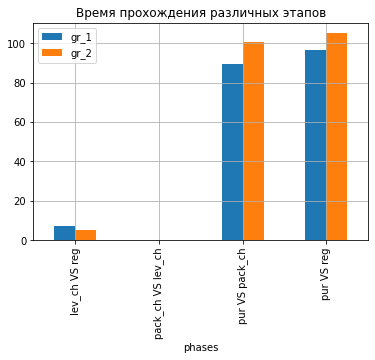

In [72]:
mean_df_total.plot(x= 'phases', kind = 'bar', grid = True, title = 'Время прохождения различных этапов')

т.к. результатов по среднему времени между pack_choice и level_choice не видно на графике, отобразим каждый временной промежуток на отдельном графике:

Text(0, 0.5, 'Часы')

<Figure size 432x288 with 0 Axes>

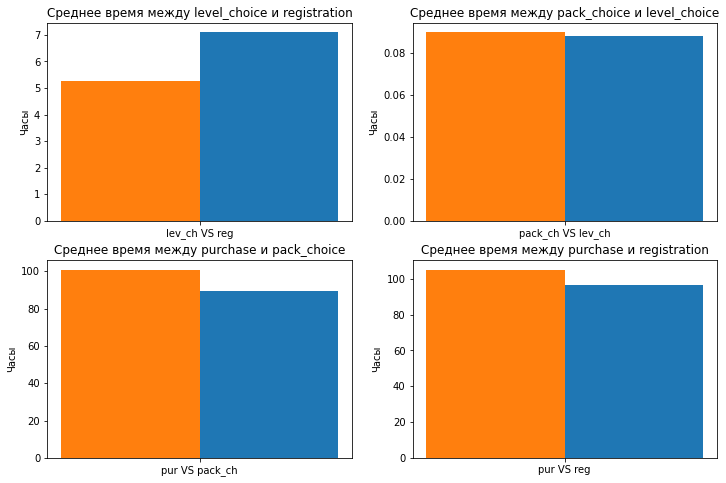

In [73]:
fig = plt.figure()
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes[0][0].bar(x = mean_df_total['phases'][0], height = mean_df_total['gr_1'][0], width = 0.4, align = 'edge')
axes[0][0].bar(x = mean_df_total['phases'][0], height = mean_df_total['gr_2'][0], width = -0.4, align = 'edge')
axes[0][0].set_title('Среднее время между level_choice и registration')
axes[0][0].set_ylabel('Часы')

axes[0][1].bar(x = mean_df_total['phases'][1], height = mean_df_total['gr_1'][1], width = 0.4, align = 'edge')
axes[0][1].bar(x = mean_df_total['phases'][1], height = mean_df_total['gr_2'][1], width = -0.4, align = 'edge')
axes[0][1].set_title('Среднее время между pack_choice и level_choice')
axes[0][1].set_ylabel('Часы')

axes[1][0].bar(x = mean_df_total['phases'][2], height = mean_df_total['gr_1'][2], width = 0.4, align = 'edge')
axes[1][0].bar(x = mean_df_total['phases'][2], height = mean_df_total['gr_2'][2], width = -0.4, align = 'edge')
axes[1][0].set_title('Среднее время между purchase и pack_choice')
axes[1][0].set_ylabel('Часы')

axes[1][1].bar(x = mean_df_total['phases'][3], height = mean_df_total['gr_1'][3], width = 0.4, align = 'edge')
axes[1][1].bar(x = mean_df_total['phases'][3], height = mean_df_total['gr_2'][3], width = -0.4, align = 'edge')
axes[1][1].set_title('Среднее время между purchase и registration')
axes[1][1].set_ylabel('Часы')

# Выводы по гипотезе 1: Отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение.
✔</b> Насколько обучение сокращает время прохождения этапов?
<br>✔</b> По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

<b>Среднее время между level_choice и registration для gr_1: 7ч 5мин. Для gr_2: 5ч 15мин.</b> Это легко объясняется тем, что пользователи, начавшие обучение тратят на него время и приступают к выбору уровня сложности в среднем на 2 часа позже, чем пользователи,не начинавшие обучение. Но если посмотреть на затрачиваемое время 75% пользователей, то увидим, что для группы 1 - это 9ч 25мин, а для 2 группы - это 8ч 24мин, т.е. к выбору уровня сложности пользователи, прошедшие обучение приступают в целом всего лишь на час позже, чем пользователи, не проходившие обучение.

<b>Среднее время между pack_choice и level_choice для gr_1: 5мин. Для gr_2: 5мин.</b> Таким образом, обучение не влияет в среднем на скорость выбора вопросов после выбора уровня сложности.

<b>Среднее время между purchase и pack_choice для gr_1: 3 дня 17ч 17мин. Для gr_2: 4 дня 04ч 49мин</b> Здесь можно сказать, что пользователи, прошедшие обучение совершают покупку в среднем на 11 часов раньше, чем пользователи, не прошедшие обучение. Вероятно, для пользователей, прошедших обучение более понятно для чего необходимо совершение покупки  и, возможно, более понятно, как совершать эту покупку (технически). Зависит от сути обучения. 

<b>Среднее время между purchase и registration для gr_1: 4 дня 30мин. Для gr_2: 4 дня 9ч 6мин</b>Таким образом, несмотря на то, что пользователи, прошедшие обучение, тратят на него временя, к покупке после регистрации они переходят все равно быстрее в среднем на 8часов, чем пользователи, не проходившие обучение. Поэтому могу сделать вывод, что обучение влияет на скорость покупки и в целом на скорорость прохождения всех этапов, и несмотря на затраты во времени на обучение, оно сокращает общее время от регистрации до покупки.

# Проверка гипотезы 2: Cуществует ли зависимость между вероятностью оплаты и количеством обучений, которые начинал или завершал пользователь.</b> 
<br>✔ Нужно доказать, что успешное обучение само по себе влияет на оплату, и без разницы, каким этапом оно шло.
<br>✔ Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

<b>Для ответа на вопросы:</b>
<br>1. Выделю группу пользователей, которые начали и закончили обучение (tutorial_finish_users) и из них:
    <br> 1.1. выделю пользователей которые закончили обучение только 1 раз
    <br> 1.2. выделю пользователей которые закончили обучение более 1 раза
<br>2. Выделю группу пользователей, которые не начинали обучение или которые начинали, но не закончили (т.е. все, кто его не закончил) - по сути это все остальные пользователи, кто не вошел в гр.1
<br>3. Посчитаю % оплат в гр. 1.1. и 1.2. - это будет ответом на вопрос влияет ли количество обучений на совершение оплаты
<br>4. Посчитаю % оплат в гр. 2 - это будет ответом на вопрос влияет ли обучение в целом на совершение оплаты

In [74]:
 # 1 - пользователи, закончившие обучение (всего)
tutorial_finish_users_unique = tutorial_finish_users.unique()

df_tutorial_finish_users_cnt = tutorial_finish_users.value_counts().reset_index()
df_tutorial_finish_users_cnt.columns = ['user_id', 'user_id_cnt']
 # 1.1 - пользователи, закончившие обучение только 1 раз
df_tutorial_finish_users_cnt_1 = df_tutorial_finish_users_cnt[df_tutorial_finish_users_cnt['user_id_cnt'] == 1]
tutorial_finish_users_cnt_1 = df_tutorial_finish_users_cnt_1['user_id']

In [75]:
# максимальное количество прохождений обучений
df_tutorial_finish_users_cnt['user_id_cnt'].max()

9

In [76]:
 # 1.2 - пользователи, закончившие обучение более 1 раза
df_tutorial_finish_users_cnt_more1 = df_tutorial_finish_users_cnt.drop(df_tutorial_finish_users_cnt[df_tutorial_finish_users_cnt['user_id_cnt'] == 1].index)
tutorial_finish_users_cnt_more1 = df_tutorial_finish_users_cnt_more1['user_id']
df_tutorial_finish_users_cnt_2 = df_tutorial_finish_users_cnt[df_tutorial_finish_users_cnt['user_id_cnt'] == 2]
tutorial_finish_users_cnt_2 = df_tutorial_finish_users_cnt_2['user_id']
df_tutorial_finish_users_cnt_3 = df_tutorial_finish_users_cnt[df_tutorial_finish_users_cnt['user_id_cnt'] == 3]
tutorial_finish_users_cnt_3 = df_tutorial_finish_users_cnt_3['user_id']
df_tutorial_finish_users_cnt_4 = df_tutorial_finish_users_cnt[df_tutorial_finish_users_cnt['user_id_cnt'] == 4]
tutorial_finish_users_cnt_4 = df_tutorial_finish_users_cnt_4['user_id']
df_tutorial_finish_users_cnt_5 = df_tutorial_finish_users_cnt[df_tutorial_finish_users_cnt['user_id_cnt'] == 5]
tutorial_finish_users_cnt_5 = df_tutorial_finish_users_cnt_5['user_id']
df_tutorial_finish_users_cnt_6 = df_tutorial_finish_users_cnt[df_tutorial_finish_users_cnt['user_id_cnt'] == 6]
tutorial_finish_users_cnt_6 = df_tutorial_finish_users_cnt_6['user_id']
df_tutorial_finish_users_cnt_7 = df_tutorial_finish_users_cnt[df_tutorial_finish_users_cnt['user_id_cnt'] == 7]
tutorial_finish_users_cnt_7 = df_tutorial_finish_users_cnt_7['user_id']
df_tutorial_finish_users_cnt_8 = df_tutorial_finish_users_cnt[df_tutorial_finish_users_cnt['user_id_cnt'] == 8]
tutorial_finish_users_cnt_8 = df_tutorial_finish_users_cnt_8['user_id']
df_tutorial_finish_users_cnt_9 = df_tutorial_finish_users_cnt[df_tutorial_finish_users_cnt['user_id_cnt'] == 9]
tutorial_finish_users_cnt_9 = df_tutorial_finish_users_cnt_9['user_id']

In [77]:
 # 2 - пользователи, которые не начинали обучение или которые начинали, но не закончили
df_wo_tutorial_finish_users = total_events_df_2018.drop(total_events_df_2018[total_events_df_2018['user_id'].isin(tutorial_finish_users)].index)
wo_tutorial_finish_users = df_wo_tutorial_finish_users['user_id'].unique()

In [78]:
user_groups = [
    {'1 - завершившие обучение': tutorial_finish_users_unique},
    {'1.1 - завершившие 1 раз': tutorial_finish_users_cnt_1},
    {'1.2 total - завершившие более 1 раза': tutorial_finish_users_cnt_more1},
    {'1.2-2 - завершившие 2 раза': tutorial_finish_users_cnt_2},
    {'1.2-3 - завершившие 3 раза': tutorial_finish_users_cnt_3},
    {'1.2-4 - завершившие 4 раза': tutorial_finish_users_cnt_4},
    {'1.2-5 - завершившие 5 раз': tutorial_finish_users_cnt_5},
    {'1.2-6 - завершившие 6 раз': tutorial_finish_users_cnt_6},
    {'1.2-7 - завершившие 7 раз': tutorial_finish_users_cnt_7},
    {'1.2-8 - завершившие 8 раза': tutorial_finish_users_cnt_8},
    {'1.2-9 - завершившие 9 раза': tutorial_finish_users_cnt_9},
    {'2 - не завершившие обчучение': wo_tutorial_finish_users}
]

l = []
user_group_list = []

for group in user_groups:
    user_group = list(group.keys())[0] # gr_1 и gr_2
    users_in_group = group[user_group] # tutorial_finish_users_cnt_1, ... 
    count_of_users_in_group = len(users_in_group)
    purchase_df_slice = purchase_df_2018[purchase_df_2018['user_id'].isin(users_in_group)]
    percent_of_purchase = purchase_df_slice['user_id'].nunique()/count_of_users_in_group
    print ('Процент оплативших пользователей в группе {}: {:.2%}'.format(user_group,percent_of_purchase))
    print ()
    percent_of_purchase = round (percent_of_purchase *100, 2)
    l.append (percent_of_purchase)
    user_group_list.append (user_group)

Процент оплативших пользователей в группе 1 - завершившие обучение: 14.12%

Процент оплативших пользователей в группе 1.1 - завершившие 1 раз: 14.26%

Процент оплативших пользователей в группе 1.2 total - завершившие более 1 раза: 13.60%

Процент оплативших пользователей в группе 1.2-2 - завершившие 2 раза: 13.78%

Процент оплативших пользователей в группе 1.2-3 - завершившие 3 раза: 12.75%

Процент оплативших пользователей в группе 1.2-4 - завершившие 4 раза: 10.67%

Процент оплативших пользователей в группе 1.2-5 - завершившие 5 раз: 16.24%

Процент оплативших пользователей в группе 1.2-6 - завершившие 6 раз: 14.85%

Процент оплативших пользователей в группе 1.2-7 - завершившие 7 раз: 15.46%

Процент оплативших пользователей в группе 1.2-8 - завершившие 8 раза: 11.11%

Процент оплативших пользователей в группе 1.2-9 - завершившие 9 раза: 18.18%

Процент оплативших пользователей в группе 2 - не завершившие обчучение: 1.58%



##### Визуализация

In [79]:
d = {}
d ['% оплат'] = l
df_for_visualisation = pd.DataFrame(d, index = user_group_list)
df_for_visualisation

,% оплат
1 - завершившие обучение,14.12
1.1 - завершившие 1 раз,14.26
1.2 total - завершившие более 1 раза,13.60
1.2-2 - завершившие 2 раза,13.78
1.2-3 - завершившие 3 раза,12.75
1.2-4 - завершившие 4 раза,10.67
1.2-5 - завершившие 5 раз,16.24
1.2-6 - завершившие 6 раз,14.85
1.2-7 - завершившие 7 раз,15.46
1.2-8 - завершившие 8 раза,11.11


<AxesSubplot:title={'center':'% оплат по группам'}>

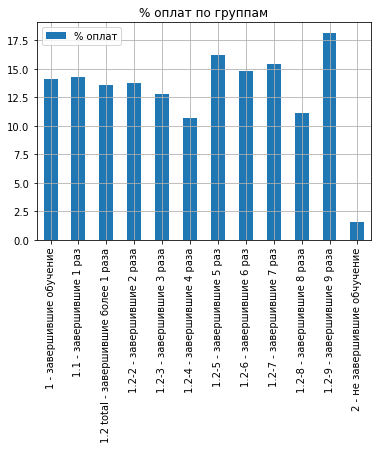

In [80]:
df_for_visualisation.plot (kind = 'bar', grid = True, title = '% оплат по группам')

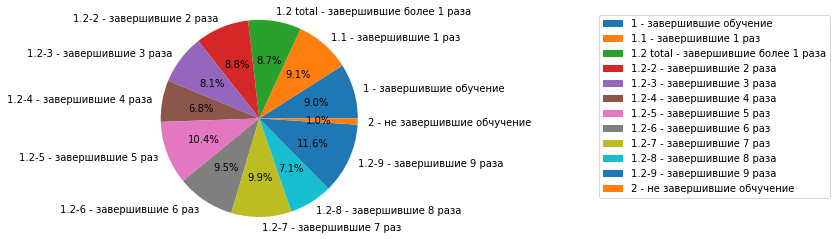

In [81]:
fig1, ax1 = plt.subplots()

plt.pie(l,labels=user_group_list,autopct='%1.1f%%')
plt.axis('equal')
ax1.legend(loc='upper left', bbox_to_anchor=(1.5, 1.0))
plt.show()

# Выводы по гипотезе 2: Cуществует ли зависимость между вероятностью оплаты и количеством обучений, которые начинал или завершал пользователь.</b> 
<br>✔ Нужно доказать, что успешное обучение само по себе влияет на оплату, и без разницы, каким этапом оно шло.
<br>✔ Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

<br>Подтвердилась гипотеза, что успешное обучение само по себе влияет на оплату. Так, в группе 1, где пользователи прошли обучение хотя бы 1 раз процент оплат 14.12%, а в группе 2, где пользователи не заканчивали обучение процент оплат всего 1.58%

<br>Повторное прохождение обучения не всегда положительно влияет на оплату. В группе 1.1, где пользователи завершали обучение всего 1 раз  процент оплаты 14.26%, а у пользователей,которые проходили обучение от 2 до 9 раз общий процент оплат составляет 13.6% и колеблется среди групп от 10.67% (пользователи,прошедшие обучение 4 раза) до 18.18% (пользователи, прошедшие обучение 9 раз). В целом, непонятно, почему пользователи могут проходить обучение стольчасто. Заметно, что процент оплат у пользователей,которые прошли обучение 5,6,7 и 9 раз процент оплат выше,чем общий процент по группе пользователей, прошедших обучение. Нужно выяснять причины такого частого обращения к обучнию. Вероятн не все понятно во flow игры.

# Проверка гипотезы 3: Как часто пользователи начинают обучение после того, как они выбрали уровень сложности. 
✔ Это позволит нам понять, насколько прозрачен процесс взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.
<br>✔ Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

Для ответа на вопрос необходимо найти количество пользователей, которые начали обучение после выбора уровня сложности и посчитать % таких пользователей от общего числа пользователей

Чтобы выделить пользователей, которые начали обучение после выбора уровня сложности, необходимо:
1. Создать датасет со всеми событиями level_choice (event_type,start_time,user_id)
2. Создать датасет со всеми событиями tutorial_start (event_type,start_time,user_id)
3. Объединить эти датасеты по user_id с помощью merge
4. Отфильтровать те строки, где время события tutorial_start позже события level_choice

In [82]:
level_choice_df = total_events_df_2018[total_events_df_2018['event_type'] == 'level_choice']
level_choice_df = level_choice_df[['user_id','event_type','start_time']].rename(columns={'event_type':'level_choice_event','start_time':'level_choice_time'})
level_choice_df['user_id'].value_counts().mean()

1.0

In [83]:
tutorial_start_df = total_events_df_2018[total_events_df_2018['event_type'] == 'tutorial_start']
tutorial_start_df = tutorial_start_df[['user_id','event_type','start_time']].rename(columns={'event_type':'tutorial_start_event','start_time':'tutorial_start_time'})
tutorial_start_df['user_id'].value_counts().mean()

1.522179119581717

Как видно,некоторые пользователи начинали обучение несколько раз, но уровень сложности выбирали только один раз

In [84]:
merged_tutorial_start_level_choice_df = level_choice_df.merge(tutorial_start_df,on='user_id',how='left')
merged_tutorial_start_level_choice_df.head()

,user_id,level_choice_event,level_choice_time,tutorial_start_event,tutorial_start_time
0,27835,level_choice,2018-01-01 20:37:22,tutorial_start,2018-01-01 15:00:51
1,27839,level_choice,2018-01-01 22:37:50,tutorial_start,2018-01-01 19:11:36
2,27840,level_choice,2018-01-02 05:18:42,tutorial_start,2018-01-02 02:07:07
3,27845,level_choice,2018-01-02 06:19:18,tutorial_start,2018-01-02 03:03:44
4,27845,level_choice,2018-01-02 06:19:18,tutorial_start,2018-01-02 07:08:00


In [85]:
# оставляем только тех пользователей, которые начинали обучение после выбора уровня сложности
tutorial_start_after_level_choice_df = \
    merged_tutorial_start_level_choice_df[merged_tutorial_start_level_choice_df['level_choice_time'] < \
                                          merged_tutorial_start_level_choice_df['tutorial_start_time']]
# считаем % пользователей
percent_of_users_start_tutorial_after_level_choice = tutorial_start_after_level_choice_df['user_id'].nunique() / total_events_df_2018['user_id'].nunique()
print ('Процент пользователей, которые начали обучение после выбора уровня сложности (среди всех пользователей): {:.2%}'\
       .format(percent_of_users_start_tutorial_after_level_choice))
print ('__________')
# дополнительно
# считаем сколько раз начинали эти пользователи обучениe
tutorial_start_after_level_choice_by_user = tutorial_start_after_level_choice_df.groupby(['user_id'])['tutorial_start_time'].count()
tutorial_start_after_level_choice_by_user_df = tutorial_start_after_level_choice_by_user.reset_index()
# считаем сколько пользователей начинало обучение в разбивке по количеству начатых обучений
tutorial_start_after_level_choice_by_user_count = tutorial_start_after_level_choice_by_user_df.groupby(['tutorial_start_time'])['user_id'].count()
tutorial_start_after_level_choice_by_user_count_df = tutorial_start_after_level_choice_by_user_count.reset_index()
tutorial_start_after_level_choice_by_user_count_df.columns = ['tutorial_start_count', 'user_id_count']
print ('Количество пользователей, которые начали обучение в разбивке по количеству обучений')
print (tutorial_start_after_level_choice_by_user_count_df)

Процент пользователей, которые начали обучение после выбора уровня сложности (среди всех пользователей): 6.96%
__________
Количество пользователей, которые начали обучение в разбивке по количеству обучений
   tutorial_start_count  user_id_count
0                     1            819
1                     2            229
2                     3            116
3                     4             77
4                     5             57
5                     6             51
6                     7             28
7                     8              9


In [86]:
tutorial_start_after_level_choice_by_user_count_df['percent'] = ( tutorial_start_after_level_choice_by_user_count_df['user_id_count']\
    /tutorial_start_after_level_choice_by_user_count_df['user_id_count'].sum() )*100
tutorial_start_after_level_choice_by_user_count_df

,tutorial_start_count,user_id_count,percent
0,1,819,59.090909
1,2,229,16.522367
2,3,116,8.369408
3,4,77,5.555556
4,5,57,4.112554
5,6,51,3.679654
6,7,28,2.020202
7,8,9,0.649351


# Выводы по гипотезе 3: Как часто пользователи начинают обучение после того, как они выбрали уровень сложности. 
✔ Почти 7% пользователей (6,96%) возвращаются к обучению после выбора уровня сложности. Причем некоторые из них делают это не единократно. Так, 59% пользователей, которые возвараются к обучению после выбора уровня сложности делают это только 1 раз, но остальные пользователи из данной группы возвращались к обучению от 2 до 8 раз. Такие показатели могут говорить о том, что процесс взаимодействия с игрой не до конца прозрачен и значит, что работа с приложением в некоторых случаях непонятна.